In [1]:
from __future__ import print_function, division
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from IPython.core.pylabtools import figsize
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

# Modeling Approaches

Starting point: "How your data might have been generated?"

Text-message data:

1. We started by thinking, "What is the best random variable to describe this count data?" A Poisson random variable is a good candidate because it can represent count data well. So we model the number of text messages received as sampled from Poisson Distribution.

2. Next we think, "Ok, assuming text messages are Poisson-distributed, what do I need for the Poisson Distribution?" Well, the Poisson Distribution has a parameter $\lambda$. 

3. Do we know $\lambda$? No, in fact, we have suspicion that there are two $\lambda$ value, one for later behaviour. We don't know when the behaviour switches, though, but we call the switchpoint $\tau$.

4. What is a good distribution for the two $\lambda$s? The exponential is good, as it assigns probabilities to positive real numbers. Well, the exponential distribution has a parameter too - call it $\alpha$.

5. Do we know what the parameter $\alpha$ might be? No. At this point, we could continue and assign a distribution to $\alpha$, but it's better to stop once we reach a set level of ignorance; whereas we have a prior belief about $\lambda$ ("It probably changes over time", "It's likely between 10 and 30," etc.), we don't really have any strong beliefs about $\alpha$. So, it's best to stop modeling here.

What is a good value for $\alpha$, then? We think that the $\lambda$s are between 10 and 30, so if we set $\alpha$ really low (which corresponds to larger probability on high values) we are not reflecting our prior well. Similarly, a too-high $\alpha$ misses our prior belief as well. A good idea for $\alpha$ to reflect our beliefs about $\lambda$ is to set the value so that the mean of $\lambda$, given $\alpha$, is equal to our observed mean.

6. We have no expert opinion of when $\tau$ might have occured. So we will suppose $\tau$ is from a discrete uniform distribution over the entire time span.

# Same Story, Different Ending

1. Specify when the user's behaviour switches by sampling from `DiscreteUniform(0,80)`:

In [2]:
tau = pm.rdiscrete_uniform(0, 80)
print(tau)

29


2. Draw $\lambda_1$ and $\lambda_2$ from an $\text{Exp}(\alpha)$ distribution:

In [3]:
alpha = 1/20
lambda_1, lambda_2 = pm.rexponential(alpha, 2)
print(lambda_1, lambda_2)

70.1182745416194 3.524378718922097


3. For days before $\tau$, $\lambda=\lambda_1$; for days after $\tau$, $\lambda = \lambda_2$ 

In [4]:
lambda_ = np.r_[lambda_1*np.ones(tau), lambda_2*np.ones(80-tau)] 
print(lambda_)

[70.11827454 70.11827454 70.11827454 70.11827454 70.11827454 70.11827454
 70.11827454 70.11827454 70.11827454 70.11827454 70.11827454 70.11827454
 70.11827454 70.11827454 70.11827454 70.11827454 70.11827454 70.11827454
 70.11827454 70.11827454 70.11827454 70.11827454 70.11827454 70.11827454
 70.11827454 70.11827454 70.11827454 70.11827454 70.11827454  3.52437872
  3.52437872  3.52437872  3.52437872  3.52437872  3.52437872  3.52437872
  3.52437872  3.52437872  3.52437872  3.52437872  3.52437872  3.52437872
  3.52437872  3.52437872  3.52437872  3.52437872  3.52437872  3.52437872
  3.52437872  3.52437872  3.52437872  3.52437872  3.52437872  3.52437872
  3.52437872  3.52437872  3.52437872  3.52437872  3.52437872  3.52437872
  3.52437872  3.52437872  3.52437872  3.52437872  3.52437872  3.52437872
  3.52437872  3.52437872  3.52437872  3.52437872  3.52437872  3.52437872
  3.52437872  3.52437872  3.52437872  3.52437872  3.52437872  3.52437872
  3.52437872  3.52437872]


4. Sample from $\text{Poi}(\lambda_1)$ and sample from $\text{Poi}(\lambda_2)$

In [5]:
data = pm.rpoisson(lambda_)
print(data)

[68 55 72 68 78 64 65 73 91 70 62 65 78 71 68 84 82 70 70 60 72 65 74 82
 77 75 92 73 73  0  1  3  3  5  6  4  3  2  4  4  3  2  2  4  6  4  5  5
  5  8  3  2  1  6  3  3  2  2  3  2  2  0  3  1  4  3  6  4  5  3  4  4
  2  1  2  6  1  4  5  1]


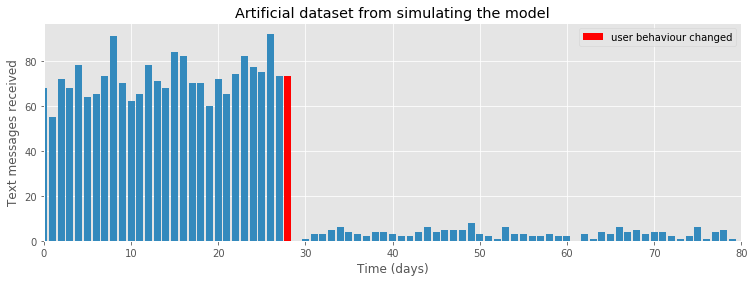

In [6]:
figsize(12.5, 4);
plt.bar(np.arange(80), data, color="#348ABD");
plt.bar(tau -1, data[tau - 1], color='r', label='user behaviour changed');
plt.xlabel('Time (days)');
plt.ylabel('Text messages received');
plt.title('Artificial dataset from simulating the model');
plt.xlim(0, 80);
plt.legend();

In [7]:
def plot_artificial_sms_dataset():
    tau = pm.rdiscrete_uniform(0, 80)
    alpha = 1/20
    lambda_1, lambda_2 = pm.rexponential(alpha, 2)
    data = np.r_[pm.rpoisson(lambda_1, tau), pm.rpoisson(lambda_2, 80 - tau)]
    plt.bar(np.arange(80), data, color='#348ABD')
    plt.bar(tau - 1, data[tau - 1], color='r',
           label='user behaviour changed');
    plt.xlim(0, 80);
    plt.xlabel('Time (days)');
    plt.ylabel('Text messages received');

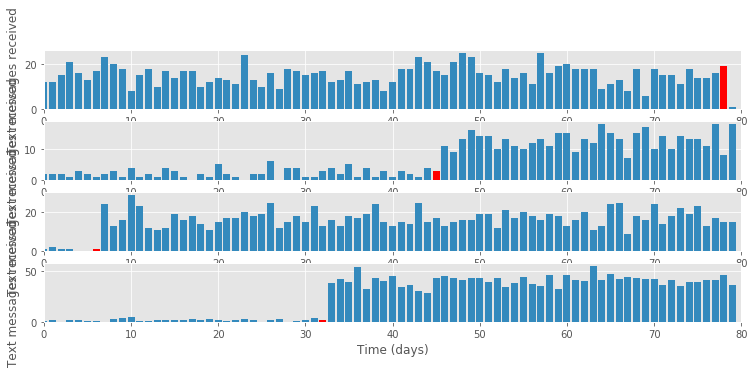

In [8]:
figsize(12.5, 5);
plt.title('More examples of artificial datasets from\
 simulating out model');
for i in range(4):
    plt.subplot(4, 1, i + 1);
    plot_artificial_sms_dataset();

plt.xlabel('Time (days)');
plt.ylabel('Text messages received');    

# Example: Bayesian A/B Testing

A/B testing $\rightarrow$ a statistical design pattern for determining the difference of effectiveness between two different treatments. 

Example:
* Effectiveness of drug A vs drug B? Split 50% - 50%
* Only a single difference between groups.

* $N$: total visitor
* $n$: number of conversions
*  A priori: Don't know (assign the uniform distribution: $p_{a} ~ [0,1]$

In [9]:
# The parameters are the bounds of the Uniform
p = pm.Uniform('p', lower=0, upper=1)

Example $p_{a} = 0.05$, $N = 1,500$, simulate whether the user made a purchase or not using Bernoulli Dist (binary random variable (0 or 1)).

$$X \sim Ber(p)$$
* $X$ is 1, with $p$
* $X$ is 0, with $p-1$

In [10]:
# set constants
p_true = .05 # remember, this is unknown in the real-life
N = 1500

# Sample N Bernoulli random variables from Ber(0.05)
# Each random variable has a 0.05 chance of being a 1.
# This is the data-generation step
occurrences = pm.rbernoulli(p_true, N) 

print(occurrences)
print(occurrences.sum())

[False False False ... False False False]
75


In [11]:
# Observed frequency:
## Occurences mean() is equal to n/N
print("What is the observed frequency in Group A? %.4f" % occurrences.mean())
print("Does the observed frequency equal the true frequency? %s" 
     %(occurrences.mean() == p_true))

What is the observed frequency in Group A? 0.0500
Does the observed frequency equal the true frequency? True


In [12]:
# Include the observations, which are Bernoulli
obs = pm.Bernoulli("obs", p, value=occurrences, observed=True)

# to be explained in Ch.3
mcmc = pm.MCMC([p, obs])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 1.3 sec

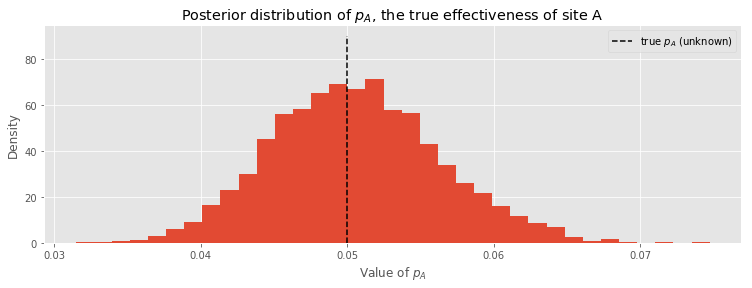

In [13]:
# prior distribution of unknown pa 
figsize(12.5, 4)
plt.title('Posterior distribution of $p_A$, the true effectiveness of site A');
plt.vlines(p_true, 0, 90, linestyles='--', label='true $p_A$ (unknown)');
plt.hist(mcmc.trace("p")[:], bins=35, histtype='stepfilled', normed=True);
plt.xlabel("Value of $p_A$");
plt.ylabel('Density');
plt.legend();

## A & B Together

$p_A$, $p_B$, and $\delta = p_{A} - p_{B}$

In [15]:
# These two quantitative are unknown to us
true_p_A = 0.05
true_p_B = 0.04

# Notice the unequal sample sizes-no problem in Bayesian analysis
N_A = 1500
N_B = 750

# Generate some observations
obs_A = pm.rbernoulli(true_p_A, N_A)
obs_B = pm.rbernoulli(true_p_B, N_B)
print("Obs from Site A: ", obs_A[:30].astype(int), "...")
print("Obs from Site B: ", obs_B[:30].astype(int), "...")

print(obs_A.mean())
print(obs_B.mean())

Obs from Site A:  [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
0.046
0.04533333333333334


In [16]:
# Set up the PyMC model. Again assume Uniform priors for p_A and p_B
p_A = pm.Uniform("p_A", 0, 1)
p_B = pm.Uniform("p_B", 0, 1)

In [17]:
"""
Define the deterministic delta function.
This is our unknown of interest.
"""
@pm.deterministic
def delta(p_A = p_A, p_B = p_B):
    return p_A - p_B

In [18]:
# Set of observations; in this case we have two observation datasets
obs_A = pm.Bernoulli("obs_A", p_A, value=obs_A, observed=True)
obs_B = pm.Bernoulli("obs_B", p_B, value=obs_B, observed=True)

In [19]:
# to be explained in ch3
mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(25000, 5000)

 [-----------------100%-----------------] 25000 of 25000 complete in 2.7 sec

In [21]:
p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]

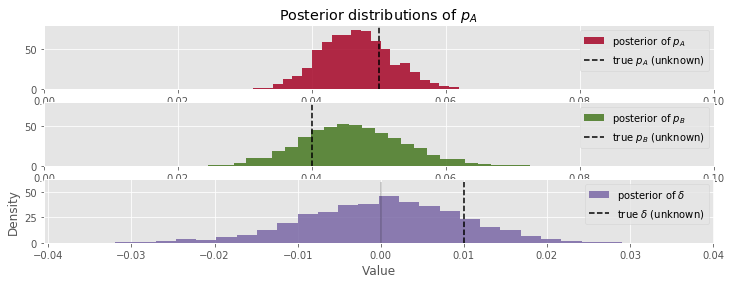

In [28]:
# Histogram of posteriors
ax = plt.subplot(311);
plt.xlim(0, .1);
plt.hist(p_A_samples, histtype='stepfilled', bins=30, alpha=.85,
        label='posterior of $p_A$', color='#A60628', normed=True);
plt.vlines(true_p_A, 0, 80, linestyles='--', 
          label='true $p_A$ (unknown)');
plt.legend(loc='upper right');
plt.title("Posterior distributions of $p_A$ ");
plt.ylim(0, 80);

ax = plt.subplot(312);
plt.xlim(0, .1);
plt.hist(p_B_samples, histtype='stepfilled', bins=30, alpha=.85,
        label='posterior of $p_B$', color="#467821", normed=True);
plt.vlines(true_p_B, 0, 80, linestyles='--',
          label="true $p_B$ (unknown)");
plt.legend(loc="upper right");
plt.ylim(0, 80);

ax = plt.subplot(313);
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=.85,
         label='posterior of $\delta$', color='#7A68A6', normed=True);
plt.vlines(true_p_A - true_p_B, 0, 60, linestyles='--', 
          label="true $\delta$ (unknown)");
plt.vlines(0, 0, 60, color='black', alpha=.2);
plt.xlabel('Value');
plt.ylabel('Density');
plt.legend(loc='upper right');

Notice that:
* $N_{B} < N_{A}$,
* $p_B$ is fatter than $p_A$
* We are less certain of $p_B$ than we are of $p_A$

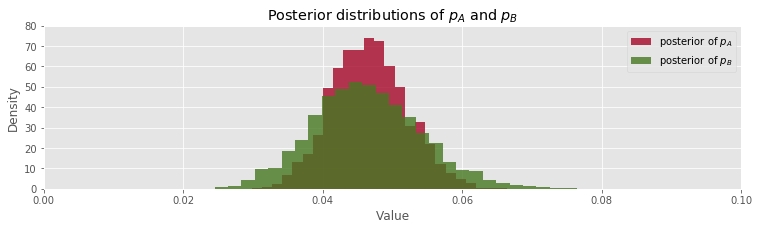

In [31]:
figsize(12.5, 3);

# Histogram of posteriors
plt.xlim(0, .1);
plt.hist(p_A_samples, histtype='stepfilled', bins=30, alpha=.8,
        label='posterior of $p_A$', color="#A60628", normed=True);
plt.hist(p_B_samples, histtype='stepfilled', bins=30, alpha=.8,
        label='posterior of $p_B$', color="#467821", normed=True);
plt.legend(loc='upper right');
plt.xlabel('Value');
plt.ylabel('Density');
plt.title('Posterior distributions of $p_A$ and $p_B$');
plt.ylim(0,80);

Majority of dist.is above delta = 0, implying that site A is likely better than B.

In [35]:
"""
Count the number of samples < 0, i.e. the area under the curve
before 0, representing the probability that site A is worse than site B
"""
print("Probability site A is WORSE than site B: %.3f" %(delta_samples < 0).mean())
print("Probability site A is BETTER than site B: %.3f" %(delta_samples > 0).mean())

Probability site A is WORSE than site B: 0.476
Probability site A is BETTER than site B: 0.524
